# Transverse Ising model in 1D

In [1]:
cd ../..

/home/ben/masterphase/Mastercode


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import qutip as qu

In [22]:
opts = qu.solver.Options()
opts.store_states = True

In [5]:
from qutip import mcsolve, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, basis

Hamiltonian:

$\displaystyle H = - \frac{1}{2}\sum_n^N h_n \sigma_z(n) - \frac{1}{2} \sum_n^{N-1} [ J_x^{(n)} \sigma_x(n) \sigma_x(n+1) + J_y^{(n)} \sigma_y(n) \sigma_y(n+1) +J_z^{(n)} \sigma_z(n) \sigma_z(n+1)]$

In [ ]:
def hamiltonian(N, h, J):
    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        #op_list[n] = sy
        #sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H += - h * sx_list[n]

    # interaction terms
    for n in range(N-1):
        #H += - 0.5 * J[n] * sx_list[n] * sx_list[n+1]
        #H += - 0.5 * J[n] * sy_list[n] * sy_list[n+1]
        H += - J[n] * sz_list[n] * sz_list[n+1]
        
    return H

In [23]:
def integrate(N, h, J, psi0, tlist, gamma, solver):
    H = hamiltonian(N, h, J)
    
    # collapse operators
    c_op_list = []

    # spin dephasing
    #for n in range(N):
    #    if gamma[n] > 0.0:
    #        c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])

    # evolve and calculate expectation values
    if solver == "me":
        result = mesolve(H, psi0, tlist, c_op_list, sz_list)
    elif solver == "mc":
        ntraj = 250 
        result = mcsolve(H, psi0, tlist, c_op_list, sz_list, ntraj, options=opts)

    return result

In [12]:
import time
import datetime
import pandas as pd
from helper.Batcher import Batcher

In [24]:
experiment = Batcher('data/spin_chain_initial/full_result.h5')

loaded store from file


In [9]:
experiment.set_data(Batcher.grid_search(particle=[15], h=np.linspace(0,2,50), solver='mc',
                                        repetition=np.arange(1), result=None))

In [26]:
for row in experiment.run(rerun=False):
    
    N = row.particle
    J = np.ones(N)
    gamma = 0 * np.ones(N)
    tlist = np.linspace(0, 200, 200)
    
    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    psi_list.append(basis(2,1))
    for n in range(N-1):
        psi_list.append(basis(2,0))
    psi0 = tensor(psi_list)
    
    row.sz_expect = integrate(row.particle, row.h, J, psi0, tlist, gamma, row.solver)

(0, 100)

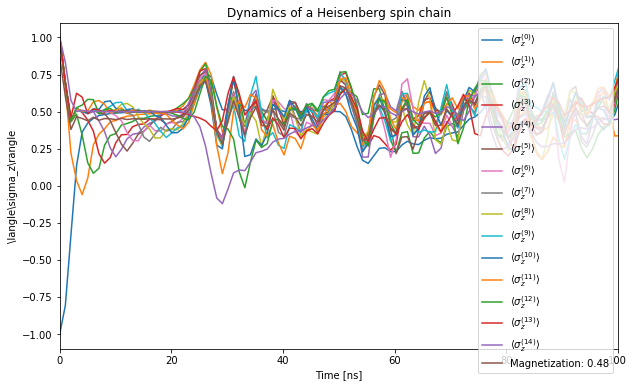

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

for n in range(N):
    ax.plot(tlist, np.real(sz_expt[n]), label=r'$\langle\sigma_z^{(%d)}\rangle$'%n)
    #ax.plot(tlist, np.real(sz_expt[n]))

m = np.mean([np.real(sz_expt[n]) for n in range(N)], axis=0)
ax.plot(tlist, m, label="Magnetization: {}".format(np.round(np.mean(m), 2)))
ax.legend(loc=0)
ax.set_xlabel(r'Time [ns]')
ax.set_ylabel(r'\langle\sigma_z\rangle')
ax.set_title(r'Dynamics of a Heisenberg spin chain')
ax.set_xlim([0, 100])